In [1]:
import pandas as pd
import hvplot.pandas
import numpy as np
import requests
import os
import json
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.stats as st
import seaborn as sns
cm=sns.light_palette("green", as_cmap=True)
cm1=sns.light_palette("blue", as_cmap=True)
cm2=sns.light_palette("purple", as_cmap=True)
cm3=sns.light_palette("#FA8128", as_cmap=True)
cm4=sns.light_palette("#F9E076", as_cmap=True)
cm5=sns.light_palette("#EE41A5", as_cmap=True)
cm6=sns.light_palette("#C14477", as_cmap=True).reversed()
cm7=sns.light_palette("#5F576E", as_cmap=True)
cm8=sns.light_palette("#16E7DA", as_cmap=True)
cm9=sns.light_palette("#11423F", as_cmap=True).reversed()
from warnings import filterwarnings
filterwarnings("ignore")
from dotenv import load_dotenv

# Load .env enviroment variables into the notebook
load_dotenv()

# Get the API key from the environment variable and store as Python variable
geoapify_key = os.getenv("geoapify_key")
census_api_key = os.getenv("census_api_key")


In [2]:
population_county_pd = pd.read_csv("Resources/population_county.csv")
population_county_pd['County'] = population_county_pd['County'].str.replace('.', '')
population_county_pd['2020'] = population_county_pd['2020'].str.replace(',', '')
population_county_pd['2021'] = population_county_pd['2021'].str.replace(',', '')
population_county_pd['2022'] = population_county_pd['2022'].str.replace(',', '')
population_county_pd['2023'] = population_county_pd['2023'].str.replace(',', '')
population_county_pd.head()

,County,2020,2021,2022,2023
0,"Autauga County, Alabama",58915,59203,59726,60342
1,"Baldwin County, Alabama",233227,239439,246531,253507
2,"Barbour County, Alabama",24969,24533,24700,24585
3,"Bibb County, Alabama",22188,22359,21986,21868
4,"Blount County, Alabama",59107,59079,59516,59816


## -----------------------------------------------------------------------------------------------------------------------------
## Finding Counties with Highest Population Growth by Number

In [3]:

population_county_pd['2020']=population_county_pd['2020'].astype(int)
population_county_pd['2021']=population_county_pd['2021'].astype(int)
population_county_pd['2022']=population_county_pd['2022'].astype(int)
population_county_pd['2023']=population_county_pd['2023'].astype(int)

In [4]:
pop_growth_percent = population_county_pd.copy()

In [5]:
population_county_pd['Pop Growth from 2020-2023']=population_county_pd['2023']-population_county_pd['2020']

In [6]:
pop_growth_pd = population_county_pd[['County', '2020', '2023', 'Pop Growth from 2020-2023']].copy()

In [7]:
pop_growth_sorted = pop_growth_pd.sort_values('Pop Growth from 2020-2023', ascending=False)

pop_growth_100 = pop_growth_sorted.iloc[0:100].copy()

In [8]:
pop_100 = pop_growth_100.set_index('County')

In [9]:
counties = []
lat = []
lon = []
for row in pop_100.iterrows():
    counties.append(row[0])

In [10]:
print(f'--------------------------------------------------')
print(f'Downloading Latitude and Longitude for each county')
for county in counties:
    target_county = county
    target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_county}&format=json&apiKey={geoapify_key}"
    response = requests.get(target_url).json()
    lat.append(response["results"][0]["lat"])
    lon.append(response["results"][0]["lon"])
    print(f'Found Latitude and Longitude for {target_county}.')
    
print('Finished searching for Latitude and Longitudes')
print(f'--------------------------------------------------')


--------------------------------------------------
Found Latitude and Longitude for Maricopa County, Arizona.
Found Latitude and Longitude for Collin County, Texas.
Found Latitude and Longitude for Harris County, Texas.
Found Latitude and Longitude for Denton County, Texas.
Found Latitude and Longitude for Polk County, Florida.
Found Latitude and Longitude for Fort Bend County, Texas.
Found Latitude and Longitude for Montgomery County, Texas.
Found Latitude and Longitude for Williamson County, Texas.
Found Latitude and Longitude for Bexar County, Texas.
Found Latitude and Longitude for Riverside County, California.
Found Latitude and Longitude for Hillsborough County, Florida.
Found Latitude and Longitude for Lee County, Florida.
Found Latitude and Longitude for Tarrant County, Texas.
Found Latitude and Longitude for Pasco County, Florida.
Found Latitude and Longitude for Clark County, Nevada.
Found Latitude and Longitude for Wake County, North Carolina.
Found Latitude and Longitude fo

In [11]:
pop_100['Latitude']=lat
pop_100['Longitude']=lon

In [12]:
pop_100.to_csv('Resources/PopulationGrowthTop100.csv')

In [13]:
pop_100

,2020,2023,Pop Growth from 2020-2023,Latitude,Longitude
County,,,,,
"Maricopa County, Arizona",4445059,4585871,140812,15.683640,-87.332920
"Collin County, Texas",1075736,1195359,119623,33.160963,-96.606098
"Harris County, Texas",4734792,4835125,100333,29.811977,-95.374125
"Denton County, Texas",914398,1007703,93305,33.183879,-97.141342
"Polk County, Florida",730158,818330,88172,27.944854,-81.726879
...,...,...,...,...,...
"Paulding County, Georgia",169580,183164,13584,33.890853,-84.856916
"Clay County, Florida",218951,232439,13488,29.976652,-81.847060
"Hunt County, Texas",100254,113347,13093,33.116157,-96.080892


In [14]:
# Obtained Median Income for Top 100 Counties by Population Growth from: https://www.census.gov/quickfacts/
median_income_df = pd.read_csv("Resources/median_household_income.csv")
top100_mediancsv = pd.read_csv("Resources/PopulationGrowthTop100.csv")
top100_median_df = top100_mediancsv[['County']]
top100_median_df = top100_median_df.merge(median_income_df, on='County', how='left')
top100_median_df = top100_median_df.dropna()
top100_median_df


,County,Median Household Income
0,"Maricopa County, Arizona",83668.0
1,"Collin County, Texas",113943.0
2,"Harris County, Texas",68748.0
3,"Denton County, Texas",102711.0
4,"Polk County, Florida",61941.0
...,...,...
94,"Loudoun County, Virginia",167605.0
95,"Paulding County, Georgia",87459.0
96,"Clay County, Florida",84364.0
97,"Hunt County, Texas",68019.0


In [15]:
pop_100median = pop_100.merge(top100_median_df, on='County')

pop_100median['Pop Growth % from 2020-2023'] = pop_100median['2023']/pop_100median['2020']*100-100
pop_100median = pop_100median[['County', 'Pop Growth from 2020-2023', 'Pop Growth % from 2020-2023', 'Median Household Income', 'Latitude', 'Longitude']]


# Code to correct incorrect Latitude and Longitudes
pop_100median.loc[pop_100median['County']=='Maricopa County, Arizona', 'Latitude'] = 33.2918
pop_100median.loc[pop_100median['County']=='Maricopa County, Arizona', 'Longitude'] = -112.4291
pop_100median.loc[pop_100median['County']=='Pinal County, Arizona', 'Latitude'] = 32.8162
pop_100median.loc[pop_100median['County']=='Pinal County, Arizona', 'Longitude'] = -111.2845
pop_100median.loc[pop_100median['County']=='Pima County, Arizona', 'Latitude'] = 32.0575
pop_100median.loc[pop_100median['County']=='Pima County, Arizona', 'Longitude'] = -111.6661
pop_100median.loc[pop_100median['County']=='Chesterfield County, Virginia', 'Latitude'] = 37.3673
pop_100median.loc[pop_100median['County']=='Chesterfield County, Virginia', 'Longitude'] = -77.6078
pop_100median.loc[pop_100median['County']=='Loudoun County, Virginia', 'Latitude'] = 39.0768
pop_100median.loc[pop_100median['County']=='Loudoun County, Virginia', 'Longitude'] = -77.6536


pop_100median

,County,Pop Growth from 2020-2023,Pop Growth % from 2020-2023,Median Household Income,Latitude,Longitude
0,"Maricopa County, Arizona",140812,3.167832,83668.0,33.291800,-112.429100
1,"Collin County, Texas",119623,11.120108,113943.0,33.160963,-96.606098
2,"Harris County, Texas",100333,2.119058,68748.0,29.811977,-95.374125
3,"Denton County, Texas",93305,10.203981,102711.0,33.183879,-97.141342
4,"Polk County, Florida",88172,12.075743,61941.0,27.944854,-81.726879
...,...,...,...,...,...,...
91,"Loudoun County, Virginia",13642,3.227310,167605.0,39.076800,-77.653600
92,"Paulding County, Georgia",13584,8.010379,87459.0,33.890853,-84.856916
93,"Clay County, Florida",13488,6.160282,84364.0,29.976652,-81.847060
94,"Hunt County, Texas",13093,13.059828,68019.0,33.116157,-96.080892


In [16]:
pop_100display = pop_100median[['County', 'Pop Growth from 2020-2023', 'Pop Growth % from 2020-2023', 'Median Household Income']]
pop_100display = pop_100display.set_index('County')
pop_100display.style.background_gradient(subset=['Pop Growth from 2020-2023'], 
                                              cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                              cmap=cm1).background_gradient(subset=['Median Household Income'], 
                                                cmap=cm).format({'Median Household Income':"${:,.0f}", 'Pop Growth from 2020-2023':"{:,.0f}", 'Pop Growth % from 2020-2023':"{:,.2f}%"})

,Pop Growth from 2020-2023,Pop Growth % from 2020-2023,Median Household Income
County,,,
"Maricopa County, Arizona","140,812",3.17%,"$83,668"
"Collin County, Texas","119,623",11.12%,"$113,943"
"Harris County, Texas","100,333",2.12%,"$68,748"
"Denton County, Texas","93,305",10.20%,"$102,711"
"Polk County, Florida","88,172",12.08%,"$61,941"
"Fort Bend County, Texas","87,669",10.57%,"$105,583"
"Montgomery County, Texas","86,063",13.76%,"$95,241"
"Williamson County, Texas","81,639",13.26%,"$101,891"
"Bexar County, Texas","72,178",3.58%,"$65,839"


The correlation between Population growth and Median Household Income is -0.04.


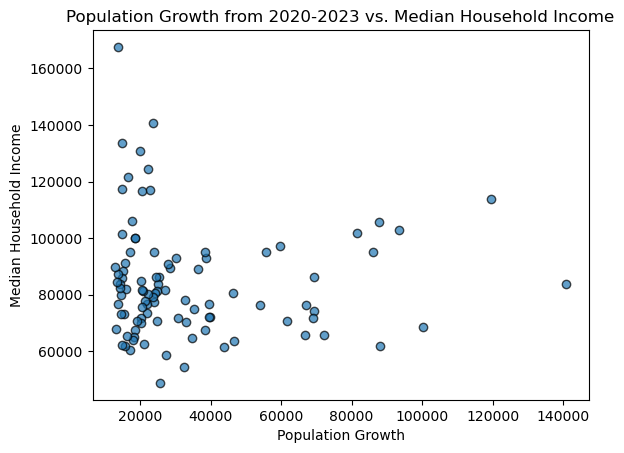

In [17]:
# Is there a correlation between population growth and median income?

x_value = pop_100median['Pop Growth from 2020-2023']
y_value = pop_100median['Median Household Income']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Population growth and Median Household Income is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black')
plt.xlabel('Population Growth')
plt.ylabel('Median Household Income')
plt.title('Population Growth from 2020-2023 vs. Median Household Income')
plt.show()
# No.  there is no correlation between Population Growth and Median Income

In [18]:
#Plot of top 100 counties in Population Growth

pop100_mapplot=pop_100median.copy()
pop100_mapplot['Median Household Income']=pop100_mapplot['Median Household Income'].map("${:,.0f}".format)
pop100_mapplot['Pop Growth from 2020-2023']=pop100_mapplot['Pop Growth from 2020-2023'].map("{:,.0f}".format)
mapplot = pop100_mapplot.hvplot.points('Longitude', 'Latitude', geo=True, tiles='OSM', legend=False,
                                   frame_width= 700, frame_height=500, alpha = 0.5, color = 'purple', title = 'Top ~100 counties by Population Growth by Number',
                                   hover_cols=['Longitude', 'Latitude', 'County', 
                                               'Pop Growth from 2020-2023', 'Median Household Income'])
mapplot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (County,Pop Growth from 2020-2023,Median Household Income)

## -----------------------------------------------------------------------------------------------------------------------------
## Finding Counties with the Highest Population Growth %

In [19]:
pop_growth_percent['Pop Growth % from 2020-2023']=population_county_pd['2023']/population_county_pd['2020']*100-100

In [20]:
pop_growth_percent = pop_growth_percent.sort_values('Pop Growth % from 2020-2023', ascending=False)

pop_growth_percentmerge = pop_growth_percent.iloc[0:100].copy()
pop_growth_percentmerge = pop_growth_percentmerge[['County','2020','2023', 'Pop Growth % from 2020-2023']].set_index('County')


In [21]:
counties1 = []
lat1 = []
lon1 = []
for row in pop_growth_percentmerge.iterrows():
    counties1.append(row[0])
print(f'--------------------------------------------------')
print(f'Downloading Latitude and Longitude for each county')
for county in counties1:
    target_county = county
    target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_county}&format=json&apiKey={geoapify_key}"
    resp = requests.get(target_url).json()
    lat1.append(resp["results"][0]["lat"])
    lon1.append(resp["results"][0]["lon"])
    print(f'Found Latitude and Longitude for {target_county}.')
    
print('Finished searching for Latitude and Longitudes')
print(f'--------------------------------------------------')

pop_growth_percentmerge['Latitude']=lat1
pop_growth_percentmerge['Longitude']=lon1


--------------------------------------------------
Found Latitude and Longitude for Kaufman County, Texas.
Found Latitude and Longitude for Long County, Georgia.
Found Latitude and Longitude for Rockwall County, Texas.
Found Latitude and Longitude for Comal County, Texas.
Found Latitude and Longitude for Dawson County, Georgia.
Found Latitude and Longitude for Custer County, Colorado.
Found Latitude and Longitude for Broadwater County, Montana.
Found Latitude and Longitude for Liberty County, Texas.
Found Latitude and Longitude for Sumter County, Florida.
Found Latitude and Longitude for Parker County, Texas.
Found Latitude and Longitude for Brunswick County, North Carolina.
Found Latitude and Longitude for St Johns County, Florida.
Found Latitude and Longitude for Jackson County, Georgia.
Found Latitude and Longitude for Jasper County, South Carolina.
Found Latitude and Longitude for Hays County, Texas.
Found Latitude and Longitude for Ellis County, Texas.
Found Latitude and Longitude

In [22]:
pop_growth_percentmerge.to_csv('Resources/Population%Top100.csv')

In [23]:
# Obtained Median Income for Top 100 Counties by Population Growth from: https://www.census.gov/quickfacts/
median_income_df = pd.read_csv("Resources/median_household_income.csv")
top100_percentmediancsv = pd.read_csv("Resources/Population%Top100.csv")
top100_percentmedian_df = top100_percentmediancsv[['County']]
top100_percentmedian_df = top100_percentmedian_df.merge(median_income_df, on='County', how='left')
top100_percentmedian_df = top100_percentmedian_df.dropna()
top100_percentmedian_df['Median Household Income']=top100_percentmedian_df['Median Household Income'].astype(int)
top100_percentmedian_df


,County,Median Household Income
0,"Kaufman County, Texas",92814
1,"Long County, Georgia",71285
2,"Rockwall County, Texas",124291
3,"Comal County, Texas",92979
4,"Dawson County, Georgia",84551
...,...,...
95,"Gem County, Idaho",60771
96,"Bay County, Florida",65521
97,"Hood County, Texas",75545
98,"Monroe County, Georgia",76428


In [24]:
top100percent_median = pop_growth_percentmerge.merge(top100_percentmedian_df, on='County', how='left')
top100percent_median = top100percent_median[['County', '2020', '2023','Pop Growth % from 2020-2023', 
                                             'Median Household Income', 'Latitude', 'Longitude']]
top100percent_median['Pop Growth from 2020-2023']=top100percent_median['2023']-top100percent_median['2020']
top100percent_median = top100percent_median.dropna()
top100percent_median=top100percent_median[['County', 'Pop Growth % from 2020-2023',
                                           'Pop Growth from 2020-2023', 'Median Household Income', 'Latitude', 'Longitude']]

# Code to correct incorrect Latitude and Longitude from API

top100percent_median.loc[top100percent_median['County']=='New Kent County, Virginia', 'Latitude'] = 37.4654
top100percent_median.loc[top100percent_median['County']=='New Kent County, Virginia', 'Longitude'] = -76.9643
top100percent_median.loc[top100percent_median['County']=='Goochland County, Virginia', 'Latitude'] = 37.7416
top100percent_median.loc[top100percent_median['County']=='Goochland County, Virginia', 'Longitude'] = -77.9739
top100percent_median.loc[top100percent_median['County']=='Pinal County, Arizona', 'Latitude'] = 32.8162
top100percent_median.loc[top100percent_median['County']=='Pinal County, Arizona', 'Longitude'] = -111.2845
top100percent_median.loc[top100percent_median['County']=='Broadwater County, Montana', 'Latitude'] = 46.2694
top100percent_median.loc[top100percent_median['County']=='Broadwater County, Montana', 'Longitude'] = -111.4520
top100percent_median.loc[top100percent_median['County']=='Musselshell County, Montana', 'Latitude'] = 46.4219
top100percent_median.loc[top100percent_median['County']=='Musselshell County, Montana', 'Longitude'] = -108.4065
top100percent_median.loc[top100percent_median['County']=='Mineral County, Montana', 'Latitude'] = 47.1497
top100percent_median.loc[top100percent_median['County']=='Mineral County, Montana', 'Longitude'] = -114.9627
top100percent_median.loc[top100percent_median['County']=='Petroleum County, Montana', 'Latitude'] = 47.1565
top100percent_median.loc[top100percent_median['County']=='Petroleum County, Montana', 'Longitude'] = -108.3203
top100percent_median.loc[top100percent_median['County']=='Lincoln County, Montana', 'Latitude'] = 48.5881
top100percent_median.loc[top100percent_median['County']=='Lincoln County, Montana', 'Longitude'] = -115.6597
top100percent_median.loc[top100percent_median['County']=='Madison County, Montana', 'Latitude'] = 45.4667
top100percent_median.loc[top100percent_median['County']=='Madison County, Montana', 'Longitude'] = -111.8865
top100percent_median.loc[top100percent_median['County']=='Sanders County, Montana', 'Latitude'] = 47.6109
top100percent_median.loc[top100percent_median['County']=='Sanders County, Montana', 'Longitude'] = -115.1317

top100percent_median

,County,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Median Household Income,Latitude,Longitude
0,"Kaufman County, Texas",26.199538,38550,92814.0,32.601641,-96.337513
1,"Long County, Georgia",20.430240,3324,71285.0,31.770490,-81.753725
2,"Rockwall County, Texas",20.290771,22149,124291.0,32.892346,-96.406699
3,"Comal County, Texas",18.495164,30269,92979.0,29.797970,-98.269079
4,"Dawson County, Georgia",17.269670,4673,84551.0,34.407708,-84.135677
...,...,...,...,...,...,...
95,"Gem County, Idaho",9.334786,1799,60771.0,44.012302,-116.384661
96,"Bay County, Florida",9.307549,16244,65521.0,30.248169,-85.659363
97,"Hood County, Texas",9.212498,5717,75545.0,32.410756,-97.828282
98,"Monroe County, Georgia",9.152796,2568,76428.0,33.014234,-83.904416


In [25]:
pop_100percentdisplay=top100percent_median[['County', 'Pop Growth % from 2020-2023', 'Pop Growth from 2020-2023', 'Median Household Income']]
pop_100percentdisplay=pop_100percentdisplay.set_index('County')
pop_100percentdisplay
pop_100percentdisplay.style.background_gradient(subset=['Median Household Income'], cmap=cm).background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).format({'Median Household Income':"${:,.0f}", 'Pop Growth % from 2020-2023':"{:,.2f}%", 'Pop Growth from 2020-2023':"{:,.0f}"})

,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Median Household Income
County,,,
"Kaufman County, Texas",26.20%,"38,550","$92,814"
"Long County, Georgia",20.43%,"3,324","$71,285"
"Rockwall County, Texas",20.29%,"22,149","$124,291"
"Comal County, Texas",18.50%,"30,269","$92,979"
"Dawson County, Georgia",17.27%,"4,673","$84,551"
"Custer County, Colorado",17.17%,811,"$67,766"
"Broadwater County, Montana",17.08%,"1,172","$67,927"
"Liberty County, Texas",17.08%,"15,793","$61,880"
"Sumter County, Florida",16.33%,"21,275","$77,851"


In [26]:
#Plot of top 100 counties in Population Growth %

pop100perc_mapplot=top100percent_median.copy()
pop100perc_mapplot['Median Household Income']=pop100perc_mapplot['Median Household Income'].map("${:,.0f}".format)
pop100perc_mapplot['Pop Growth % from 2020-2023']=pop100perc_mapplot['Pop Growth % from 2020-2023'].map("{:,.2f}%".format)
mapplot = pop100perc_mapplot.hvplot.points('Longitude', 'Latitude', geo=True, tiles='OSM', legend=False,
                                   frame_width= 700, frame_height=500, alpha = 0.5, color = 'blue', title = 'Top ~100 counties by Population Growth by %',
                                   hover_cols=['Longitude', 'Latitude', 'County', 
                                               'Pop Growth % from 2020-2023', 'Median Household Income'])
mapplot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (County,Pop Growth % from 2020-2023,Median Household Income)

## -----------------------------------------------------------------------------------------------------------------------------
## Merge Pop Growth by % and Pop Growth by Numbers

In [27]:
pop_merged = pop_100median.merge(top100percent_median, on=['County','Pop Growth from 2020-2023','Pop Growth % from 2020-2023', 
                                                           'Median Household Income', 'Latitude', 'Longitude'], how='outer')
pop_merged = pop_merged.drop_duplicates(subset=['County'])

pop_merged=pop_merged[['County','Pop Growth % from 2020-2023', 'Pop Growth from 2020-2023', 'Median Household Income', 'Latitude', 'Longitude']]
pop_merged_df = pop_merged.set_index('County')
pop_merged_display = pop_merged_df[['Pop Growth % from 2020-2023', 'Pop Growth from 2020-2023', 'Median Household Income']]
pop_merged_display = pop_merged_display.sort_values('Pop Growth % from 2020-2023', ascending=False)
pop_merged_display=pop_merged_display.style.background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).background_gradient(subset=['Median Household Income'], 
                                             cmap=cm).format({'Pop Growth % from 2020-2023':"{:,.2f}%", 
                                                               'Pop Growth from 2020-2023':"{:,.0f}",
                                                             'Median Household Income':"${:,.0f}"})
pop_merged_display

,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Median Household Income
County,,,
"Kaufman County, Texas",26.20%,"38,550","$92,814"
"Long County, Georgia",20.43%,"3,324","$71,285"
"Rockwall County, Texas",20.29%,"22,149","$124,291"
"Comal County, Texas",18.50%,"30,269","$92,979"
"Dawson County, Georgia",17.27%,"4,673","$84,551"
"Custer County, Colorado",17.17%,811,"$67,766"
"Broadwater County, Montana",17.08%,"1,172","$67,927"
"Liberty County, Texas",17.08%,"15,793","$61,880"
"Sumter County, Florida",16.33%,"21,275","$77,851"


In [28]:
#Plot of top counties in Population Growth

pop_merged_mapplot=pop_merged.copy()
pop_merged_mapplot['Median Household Income']=pop_merged_mapplot['Median Household Income'].map("${:,.0f}".format)
pop_merged_mapplot['Pop Growth % from 2020-2023']=pop_merged_mapplot['Pop Growth % from 2020-2023'].map("{:,.2f}%".format)
pop_merged_mapplot['Pop Growth from 2020-2023']=pop_merged_mapplot['Pop Growth from 2020-2023'].map("{:,.0f}".format)

mapplot = pop_merged_mapplot.hvplot.points('Longitude', 'Latitude', geo=True, tiles='OSM', legend=False,
                                    frame_width= 700, frame_height=500, alpha = 0.5, color = 'County', title = 'Top ~200 counties by Population Growth by Number and %',
                                    hover_cols=['County','Longitude', 'Latitude', 'Median Household Income', 'Pop Growth from 2020-2023', 'Pop Growth % from 2020-2023'])
mapplot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (County,Median Household Income,Pop Growth from 2020-2023,Pop Growth % from 2020-2023)

The correlation between Population Growth and Population Growth Percentage is -0.22.


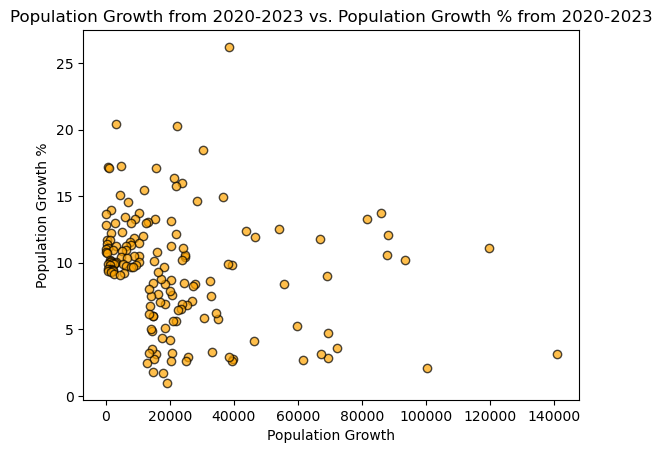

In [29]:
# Is there a correlation between population growth and population growth %?

x_value = pop_merged['Pop Growth from 2020-2023']
y_value = pop_merged['Pop Growth % from 2020-2023']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Population Growth and Population Growth Percentage is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black', color='orange')
plt.xlabel('Population Growth')
plt.ylabel('Population Growth %')
plt.title('Population Growth from 2020-2023 vs. Population Growth % from 2020-2023')
plt.show()
# No.  there is no correlation between Population Growth and Population Growth %

## Median Housing Prices by County

In [30]:
medianhousing_df = pd.read_csv("Resources/median_housing_prices.csv")
medianhousing_df['2023 Median']=medianhousing_df['2023 Median'].astype(int)
medianhousing_df['2020 Median']=medianhousing_df['2020 Median'].astype(int)
medianhousing_df['Median Price Increase']=medianhousing_df['2023 Median']-medianhousing_df['2020 Median']
medianhousing_df['Median Price % Increase']=medianhousing_df['2023 Median']/medianhousing_df['2020 Median']*100-100
medianhousing_df=medianhousing_df[['County', 'Median Home Price (2023)', 'Median Price Increase', 'Median Price % Increase']]

In [31]:
medianhousing_df

,County,Median Home Price (2023),Median Price Increase,Median Price % Increase
0,"Blount County, Alabama",255000.0,65000,34.210526
1,"Bullock County, Alabama",190000.0,45000,31.034483
2,"Butler County, Alabama",190000.0,45000,31.034483
3,"Calhoun County, Alabama",190000.0,45000,31.034483
4,"Chambers County, Alabama",190000.0,45000,31.034483
...,...,...,...,...
2998,"Sweetwater County, Wyoming",268500.0,24250,9.928352
2999,"Teton County, Wyoming",755000.0,160000,26.890756
3000,"Uinta County, Wyoming",232000.0,37000,18.974359
3001,"Washakie County, Wyoming",219500.0,52500,31.437126


In [32]:
home_median = pop_merged.merge(medianhousing_df, on=['County'], how='left')
home_median = home_median.dropna()
home_median = home_median.sort_values('Median Price % Increase', ascending=False)
home_median = home_median[['County', 'Median Price % Increase','Median Price Increase', 'Median Home Price (2023)', 'Median Household Income','Pop Growth % from 2020-2023', 
                       'Pop Growth from 2020-2023', 'Latitude', 'Longitude']]
home_mediandisplay = home_median.set_index('County')
home_mediandisplay = home_mediandisplay[['Median Price % Increase','Median Price Increase', 'Median Home Price (2023)', 'Median Household Income', 'Pop Growth % from 2020-2023', 
                       'Pop Growth from 2020-2023']]
home_mediandisplay=home_mediandisplay.style.background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).background_gradient(subset=['Median Household Income'], 
                                             cmap=cm).background_gradient(subset=['Median Price Increase'], 
                                             cmap=cm4).background_gradient(subset=['Median Price % Increase'], 
                                             cmap=cm3).background_gradient(subset=['Median Home Price (2023)'], 
                                             cmap=cm7).format({'Pop Growth % from 2020-2023':"{:,.2f}%", 
                                                               'Pop Growth from 2020-2023':"{:,.0f}",
                                                             'Median Household Income':"${:,.0f}", 'Median Price Increase':"${:,.0f}",
                                                             'Median Price % Increase':"{:,.2f}%", 'Median Home Price (2023)':"${:,.2f}"})
home_mediandisplay

,Median Price % Increase,Median Price Increase,Median Home Price (2023),Median Household Income,Pop Growth % from 2020-2023,Pop Growth from 2020-2023
County,,,,,,
"Gem County, Idaho",79.56%,"$144,000","$325,000.00","$60,771",9.33%,"1,799"
"Canyon County, Idaho",71.55%,"$171,000","$410,000.00","$70,594",10.58%,"24,661"
"Boise County, Idaho",71.55%,"$171,000","$410,000.00","$74,121",11.13%,853
"Travis County, Texas",66.13%,"$205,000","$515,000.00","$95,151",2.96%,"38,348"
"Tooele County, Utah",63.02%,"$170,100","$440,000.00","$91,353",11.85%,"8,696"
"Bonner County, Idaho",61.71%,"$166,000","$435,000.00","$64,860",10.85%,"5,144"
"Iron County, Utah",61.02%,"$144,000","$380,000.00","$66,499",11.26%,"6,498"
"Bastrop County, Texas",60.38%,"$160,000","$425,000.00","$73,403",12.97%,"12,721"
"Hays County, Texas",60.38%,"$160,000","$425,000.00","$89,074",14.97%,"36,518"


In [33]:
home_median.to_csv('Resources/Pop_home_median.csv')

## -----------------------------------------------------------------------------------------------------------------------------
## Costs of Rent vs. Mortgage

In [34]:
rentvsmortgage_df = pd.read_csv("Resources/rentvsmortgage.csv")

In [35]:
home_rent_mortgage = home_median.merge(rentvsmortgage_df, on='County', how='left')
home_rent_mortgage= home_rent_mortgage.dropna()
home_rent_mortgage= home_rent_mortgage.sort_values('Rent vs. Mortgage', ascending=False)
home_rent_mortgage_display= home_rent_mortgage.copy()
home_rent_mortgage_display=home_rent_mortgage_display[['County', 'Rent vs. Mortgage', 'Median Price % Increase','Median Price Increase', 'Median Home Price (2023)', 'Median Household Income', 'Pop Growth % from 2020-2023', 
                       'Pop Growth from 2020-2023']]
home_rent_mortgage_display=home_rent_mortgage_display.set_index('County')
home_rent_mortgage_display=home_rent_mortgage_display.style.background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).background_gradient(subset=['Median Household Income'], 
                                             cmap=cm).background_gradient(subset=['Median Price Increase'], 
                                             cmap=cm4).background_gradient(subset=['Median Price % Increase'], 
                                             cmap=cm3).background_gradient(subset=['Rent vs. Mortgage'], 
                                             cmap=cm5).background_gradient(subset=['Median Home Price (2023)'], 
                                             cmap=cm7).format({'Pop Growth % from 2020-2023':"{:,.2f}%", 
                                                               'Pop Growth from 2020-2023':"{:,.0f}",
                                                             'Median Household Income':"${:,.0f}", 'Median Price Increase':"${:,.0f}",
                                                             'Median Price % Increase':"{:,.2f}%", 'Rent vs. Mortgage':"${:,.0f}", 'Median Home Price (2023)':"${:,.2f}"})
home_rent_mortgage_display

,Rent vs. Mortgage,Median Price % Increase,Median Price Increase,Median Home Price (2023),Median Household Income,Pop Growth % from 2020-2023,Pop Growth from 2020-2023
County,,,,,,,
"Lee County, Florida",$631,51.01%,"$109,750","$324,900.00","$71,607",9.02%,"69,026"
"Sarasota County, Florida",$621,48.89%,"$110,000","$335,000.00","$78,309",7.51%,"32,776"
"Osceola County, Florida",$543,37.34%,"$87,001","$320,000.00","$63,782",11.92%,"46,643"
"Pinal County, Arizona",$535,57.02%,"$138,000","$380,000.00","$76,232",12.56%,"54,052"
"Flagler County, Florida",$533,44.32%,"$97,500","$317,500.00","$73,336",13.28%,"15,411"
"Berkeley County, South Carolina",$518,35.48%,"$82,500","$315,000.00","$79,259",10.23%,"23,684"
"Gwinnett County, Georgia",$501,53.15%,"$118,000","$340,000.00","$83,918",2.63%,"25,167"
"Guadalupe County, Texas",$499,33.31%,"$71,541","$286,290.00","$86,043",8.50%,"14,757"
"Nassau County, Florida",$467,32.88%,"$75,466","$305,000.00","$90,808",11.50%,"10,470"


In [36]:
housingunitsbuilt = pd.read_csv("Resources/housing_built.csv")
housingdatafinal = home_rent_mortgage.merge(housingunitsbuilt, on='County', how='left')


In [37]:
housingdatadisplay = housingdatafinal.copy().set_index('County')

housingdatadisplay=housingdatadisplay[['Rent vs. Mortgage', 'Median Price % Increase','Median Price Increase', 'Median Home Price (2023)','Median Household Income', 'Pop Growth % from 2020-2023', 
                        'Pop Growth from 2020-2023', 'Total Housing Units built after 2020']]
housingdatadisplay=housingdatadisplay.style.background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).background_gradient(subset=['Median Household Income'], 
                                             cmap=cm).background_gradient(subset=['Median Price Increase'], 
                                             cmap=cm4).background_gradient(subset=['Median Price % Increase'], 
                                             cmap=cm3).background_gradient(subset=['Rent vs. Mortgage'], 
                                             cmap=cm5).background_gradient(subset=['Total Housing Units built after 2020'], 
                                             cmap=cm6).background_gradient(subset=['Median Home Price (2023)'], 
                                             cmap=cm7).format({'Pop Growth % from 2020-2023':"{:,.2f}%", 
                                                               'Pop Growth from 2020-2023':"{:,.0f}",
                                                             'Median Household Income':"${:,.0f}", 'Median Price Increase':"${:,.0f}",
                                                             'Median Price % Increase':"{:,.2f}%", 
                                                               'Rent vs. Mortgage':"${:,.0f}", 
                                                               'Total Housing Units built after 2020':"{:,.0f}", 'Median Home Price (2023)':"${:,.2f}"})

In [38]:
housingdatadisplay

,Rent vs. Mortgage,Median Price % Increase,Median Price Increase,Median Home Price (2023),Median Household Income,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Total Housing Units built after 2020
County,,,,,,,,
"Lee County, Florida",$631,51.01%,"$109,750","$324,900.00","$71,607",9.02%,"69,026","14,177"
"Sarasota County, Florida",$621,48.89%,"$110,000","$335,000.00","$78,309",7.51%,"32,776","10,454"
"Osceola County, Florida",$543,37.34%,"$87,001","$320,000.00","$63,782",11.92%,"46,643","9,858"
"Pinal County, Arizona",$535,57.02%,"$138,000","$380,000.00","$76,232",12.56%,"54,052","11,656"
"Flagler County, Florida",$533,44.32%,"$97,500","$317,500.00","$73,336",13.28%,"15,411","3,229"
"Berkeley County, South Carolina",$518,35.48%,"$82,500","$315,000.00","$79,259",10.23%,"23,684","8,790"
"Gwinnett County, Georgia",$501,53.15%,"$118,000","$340,000.00","$83,918",2.63%,"25,167","10,235"
"Guadalupe County, Texas",$499,33.31%,"$71,541","$286,290.00","$86,043",8.50%,"14,757","4,382"
"Nassau County, Florida",$467,32.88%,"$75,466","$305,000.00","$90,808",11.50%,"10,470","3,828"


## API Pull from Census.gov to pull Poverty Percent

In [39]:
povertypercent=[]
povertycounty=[]
povertystate=[]
target_url = f'https://api.census.gov/data/timeseries/poverty/saipe?get=NAME,STABREV,SAEPOVRTALL_PT&for=county:*&in=state:*&time=2022&key={census_api_key}'
response = requests.get(target_url).json()
for x in range(len(response)):
    povertycounty.append(response[x][0])
for x in range(len(response)):
    povertystate.append(response[x][1])
for x in range(len(response)):
    povertypercent.append(response[x][2])

    
#print(json.dumps(response[][0], indent=4, sort_keys=True))

povertypercent_df=pd.DataFrame(povertycounty)
povertypercent_df['povertystate']=povertystate
povertypercent_df['povertypercent']=povertypercent
povertypercent_df=povertypercent_df.iloc[1:]
#List of states
abbrev2state = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming',
        'PR': 'Puerto Rico',
        'VI': 'Virigin Islands'
    }
    
povertypercent_df['povertystate'] = povertypercent_df['povertystate'].str.strip().replace(abbrev2state)
povertypercent_df=povertypercent_df.rename(columns={0:'County', 'povertystate':'State', 'povertypercent': 'Poverty Percent'})
povertypercent_df['County']=povertypercent_df['County']+', '
povertypercent_df['County']=povertypercent_df['County']+povertypercent_df['State']
povertypercent_clean = povertypercent_df[['County', 'Poverty Percent']]
povertypercent_clean

,County,Poverty Percent
1,"Autauga County, Alabama",11.8
2,"Baldwin County, Alabama",12.4
3,"Barbour County, Alabama",26.7
4,"Bibb County, Alabama",20.0
5,"Blount County, Alabama",13.6
...,...,...
3140,"Sweetwater County, Wyoming",12.4
3141,"Teton County, Wyoming",5.2
3142,"Uinta County, Wyoming",10.8
3143,"Washakie County, Wyoming",10.9


In [40]:
housingdatafinal=housingdatafinal.merge(povertypercent_clean, on='County', how='left')

## Apply score to Factors

In [41]:
labels = ['1', '2', '3','4', '5', '6', '7', '8', '9', '10']
rlabels = ['10', '9', '8','7', '6', '5', '4', '3', '2', '1']
housingdatafinal['Poverty Percent']=housingdatafinal['Poverty Percent'].astype(float)
housingdatafinal["Poverty Score"] = pd.cut(housingdatafinal['Poverty Percent'], 10, labels=rlabels)
housingdatafinal["Rent vs. Mortgage Score"] = pd.cut(housingdatafinal['Rent vs. Mortgage'], 10, labels=labels)
housingdatafinal['Demand Ratio']=housingdatafinal['Pop Growth from 2020-2023']/housingdatafinal['Total Housing Units built after 2020']
housingdatafinal['Affordability Ratio']=housingdatafinal['Median Household Income']/housingdatafinal['Total Housing Units built after 2020']
housingdatafinal['Demand Score'] = pd.cut(housingdatafinal['Demand Ratio'], 10, labels=labels)
housingdatafinal['Affordability Score'] = pd.cut(housingdatafinal['Affordability Ratio'], 10, labels=labels)
housingdatafinal["Rent vs. Mortgage Score"]=housingdatafinal["Rent vs. Mortgage Score"].astype(int)
housingdatafinal['Demand Score']=housingdatafinal['Demand Score'].astype(int)
housingdatafinal['Affordability Score']=housingdatafinal['Affordability Score'].astype(int)
housingdatafinal['Poverty Score']=housingdatafinal['Poverty Score'].astype(int)
housingdatafinal['Overall Score']=housingdatafinal['Demand Score']+housingdatafinal["Rent vs. Mortgage Score"]+housingdatafinal['Affordability Score']+housingdatafinal['Poverty Score']
housingdatafinal=housingdatafinal.sort_values('Overall Score', ascending=False)
housingdatafinal=housingdatafinal[['County','Overall Score', 'Rent vs. Mortgage Score', 'Demand Score', 'Affordability Score', 'Poverty Score', 'Rent vs. Mortgage', 'Median Price % Increase', 'Median Price Increase', 'Median Home Price (2023)','Median Household Income', 'Pop Growth % from 2020-2023', 'Pop Growth from 2020-2023', 'Total Housing Units built after 2020', 'Demand Ratio', 'Affordability Ratio', 'Poverty Percent', 'Latitude', 'Longitude']]
housingdatafinal

,County,Overall Score,Rent vs. Mortgage Score,Demand Score,Affordability Score,Poverty Score,Rent vs. Mortgage,Median Price % Increase,Median Price Increase,Median Home Price (2023),Median Household Income,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Total Housing Units built after 2020,Demand Ratio,Affordability Ratio,Poverty Percent,Latitude,Longitude
97,"Hampshire County, Massachusetts",31,4,10,10,7,15.0,30.036630,82000.0,355000.0,81878.0,10.835107,15886,476,33.373950,172.012605,11.7,42.343250,-72.621334
46,"Lincoln County, South Dakota",23,6,2,5,10,205.0,35.892017,85423.0,323423.0,98387.0,11.561662,7590,1411,5.379164,69.728561,5.3,43.272419,-96.738776
83,"Effingham County, Georgia",23,5,3,7,8,67.0,33.164903,63010.0,253000.0,88111.0,9.777655,6372,736,8.657609,119.716033,8.6,32.341963,-81.338687
33,"Hernando County, Florida",23,7,5,4,7,297.0,48.571429,102000.0,312000.0,60582.0,8.783687,17183,1019,16.862610,59.452404,12.1,28.571016,-82.460507
11,"Rockwall County, Texas",23,9,2,2,10,452.0,36.854545,93242.0,346242.5,124291.0,20.290771,22149,4565,4.851917,27.226944,4.7,32.892346,-96.406699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,"Lancaster County, South Carolina",12,1,2,2,7,-311.0,42.138220,80484.0,271484.5,70113.0,12.037727,11627,2481,4.686417,28.259976,10.6,34.662807,-80.700546
82,"Bexar County, Texas",12,5,1,1,5,70.0,31.672821,61762.0,256762.0,65839.0,3.581144,72178,34343,2.101680,1.917101,15.6,29.426399,-98.510478
96,"Liberty County, Texas",12,4,2,2,4,21.0,32.530120,67500.0,275000.0,61880.0,17.077391,15793,2081,7.589140,29.735704,19.9,30.085674,-94.785626
92,"Harris County, Texas",11,4,1,1,5,36.0,32.530120,67500.0,275000.0,68748.0,2.119058,100333,53630,1.870837,1.281894,16.4,29.811977,-95.374125


In [42]:
housingdatafinaldisplay = housingdatafinal.copy().set_index('County')

housingdatafinaldisplay=housingdatafinaldisplay[['Overall Score', 'Rent vs. Mortgage Score', 'Demand Score', 'Affordability Score', 'Poverty Score', 'Rent vs. Mortgage', 'Median Price % Increase','Median Price Increase', 'Median Home Price (2023)','Median Household Income', 'Pop Growth % from 2020-2023', 
                        'Pop Growth from 2020-2023', 'Poverty Percent', 'Total Housing Units built after 2020']]
housingdatafinaldisplay=housingdatafinaldisplay.style.background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).background_gradient(subset=['Median Household Income'], 
                                             cmap=cm).background_gradient(subset=['Median Price Increase'], 
                                             cmap=cm4).background_gradient(subset=['Median Price % Increase'], 
                                             cmap=cm3).background_gradient(subset=['Rent vs. Mortgage'], 
                                             cmap=cm5).background_gradient(subset=['Total Housing Units built after 2020'], 
                                             cmap=cm6).background_gradient(subset=['Median Home Price (2023)'], 
                                             cmap=cm7).background_gradient(subset=['Overall Score'], 
                                             cmap=cm8).background_gradient(subset=['Poverty Percent'], 
                                             cmap=cm9).format({'Pop Growth % from 2020-2023':"{:,.2f}%", 
                                                               'Pop Growth from 2020-2023':"{:,.0f}",
                                                             'Median Household Income':"${:,.0f}", 'Median Price Increase':"${:,.0f}",
                                                             'Median Price % Increase':"{:,.2f}%", 'Poverty Percent':"{:,.2f}%", 
                                                               'Rent vs. Mortgage':"${:,.0f}", 
                                                               'Total Housing Units built after 2020':"{:,.0f}", 'Median Home Price (2023)':"${:,.2f}"})


In [43]:
housingdatafinaldisplay

,Overall Score,Rent vs. Mortgage Score,Demand Score,Affordability Score,Poverty Score,Rent vs. Mortgage,Median Price % Increase,Median Price Increase,Median Home Price (2023),Median Household Income,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Poverty Percent,Total Housing Units built after 2020
County,,,,,,,,,,,,,,
"Hampshire County, Massachusetts",31,4,10,10,7,$15,30.04%,"$82,000","$355,000.00","$81,878",10.84%,"15,886",11.70%,476
"Lincoln County, South Dakota",23,6,2,5,10,$205,35.89%,"$85,423","$323,423.00","$98,387",11.56%,"7,590",5.30%,"1,411"
"Effingham County, Georgia",23,5,3,7,8,$67,33.16%,"$63,010","$253,000.00","$88,111",9.78%,"6,372",8.60%,736
"Hernando County, Florida",23,7,5,4,7,$297,48.57%,"$102,000","$312,000.00","$60,582",8.78%,"17,183",12.10%,"1,019"
"Rockwall County, Texas",23,9,2,2,10,$452,36.85%,"$93,242","$346,242.50","$124,291",20.29%,"22,149",4.70%,"4,565"
"Paulding County, Georgia",21,7,2,3,9,$298,52.38%,"$110,000","$320,000.00","$87,459",8.01%,"13,584",7.90%,"2,348"
"Flagler County, Florida",21,9,2,2,8,$533,44.32%,"$97,500","$317,500.00","$73,336",13.28%,"15,411",9.10%,"3,229"
"Union County, Ohio",21,3,2,6,10,$-82,31.71%,"$65,000","$270,000.00","$104,512",10.39%,"6,552",5.20%,"1,123"
"Nassau County, Florida",21,9,1,2,9,$467,32.88%,"$75,466","$305,000.00","$90,808",11.50%,"10,470",6.80%,"3,828"


In [44]:
housingdatafinal.to_csv('Resources/Final_overall_score.csv')

In [45]:
#Plot of top 100 counties in Population Growth %
housingtop15=housingdatafinal.iloc[0:15].copy()

housingtop15['Median Household Income']=housingtop15['Median Household Income'].map("${:,.0f}".format)
housingtop15['Pop Growth % from 2020-2023']=housingtop15['Pop Growth % from 2020-2023'].map("{:,.2f}%".format)
housingtop15['Pop Growth from 2020-2023']=housingtop15['Pop Growth from 2020-2023'].map("{:,.0f}".format)
housingtop15['Median Home Price (2023)']=housingtop15['Median Home Price (2023)'].map("{:,.0f}".format)
mapplotfinal = housingtop15.hvplot.points('Longitude', 'Latitude', geo=True, tiles='OSM', legend=False,
                                   frame_width= 700, frame_height=500, alpha = 0.5, color = 'blue', title = 'Top 15 counties by Overall Score',
                                   hover_cols=['Longitude', 'Latitude', 'County', 
                                               'Pop Growth % from 2020-2023', 'Pop Growth from 2020-2023', 'Median Home Price (2023)', 'Median Household Income'])
mapplotfinal

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (County,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Median Home Price (2023),Median Household Income)

## Correlation between Median House Price Increase vs. Population Increase by Number


The correlation between Median Price Increase and Pop Growth from 2020-2023 is 0.04.


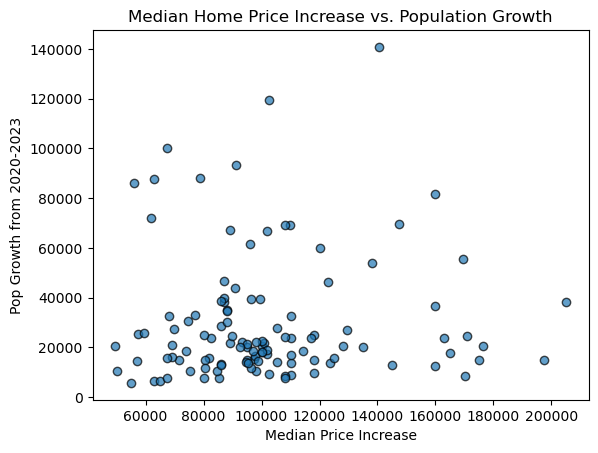

In [46]:

# Is there a correlation between Median Home Price Increases and Population Increase by Number?

x_value = housingdatafinal['Median Price Increase']
y_value = housingdatafinal['Pop Growth from 2020-2023']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Median Price Increase and Pop Growth from 2020-2023 is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black')
plt.xlabel('Median Price Increase')
plt.ylabel('Pop Growth from 2020-2023')
plt.title('Median Home Price Increase vs. Population Growth')
plt.show()
# No.  there is no correlation between between Median Home Price Increases and Population Increase by Number

The correlation between Median Price Increase and Mortgage Advantage is 0.01.


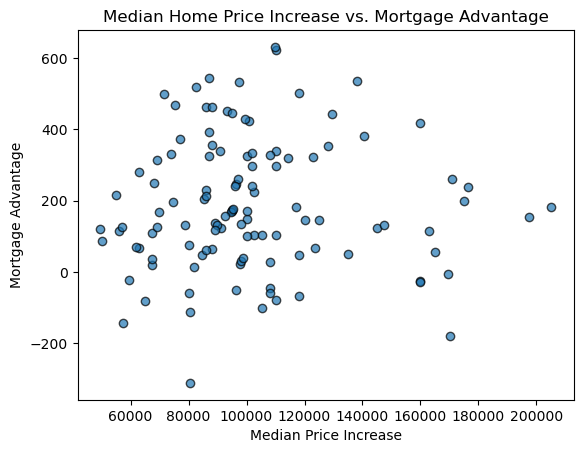

In [47]:
housingdatafinal
# Is there a correlation between Median Home Prices and Mortgage Advantage

x_value = housingdatafinal['Median Price Increase']
y_value = housingdatafinal['Rent vs. Mortgage']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Median Price Increase and Mortgage Advantage is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black')
plt.xlabel('Median Price Increase')
plt.ylabel('Mortgage Advantage')
plt.title('Median Home Price Increase vs. Mortgage Advantage')
plt.show()
# No.  there is no correlation between Median Home Prices and Mortgage Advantage

The correlation between Median Price Increase and Poverty Percent is -0.26.


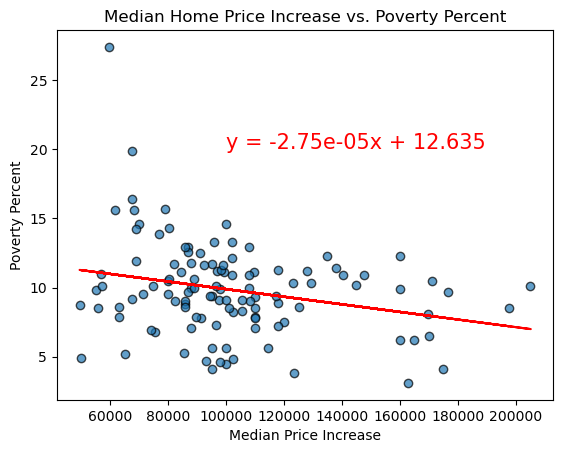

In [66]:

# Is there a correlation between Median Home Price Increases and Poverty Rate?

x_value = housingdatafinal['Median Price Increase']
y_value = housingdatafinal['Poverty Percent']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Median Price Increase and Poverty Percent is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black')
plt.xlabel('Median Price Increase')
plt.ylabel('Poverty Percent')
plt.title('Median Home Price Increase vs. Poverty Percent')

# Linear regression model

lin_reg = st.linregress(x_value, y_value) 

regress_plot = x_value*lin_reg.slope + lin_reg.intercept
lineequation = 'y = ' +str(round(lin_reg.slope,7)) + 'x + ' + str(round(lin_reg.intercept, 3))
plt.plot(x_value, regress_plot, color='red')
marker_size=15
plt.annotate(lineequation, (100000,20), fontsize=15, color = 'red')
plt.show()

# Yes.  there is a weak correlation between Median Home Price Increases and Poverty Rate

The correlation between Median Price Increase and Affordability Ratio is -0.12.


Text(0.5, 1.0, 'Median Home Price Increase vs. Affordability Ratio')

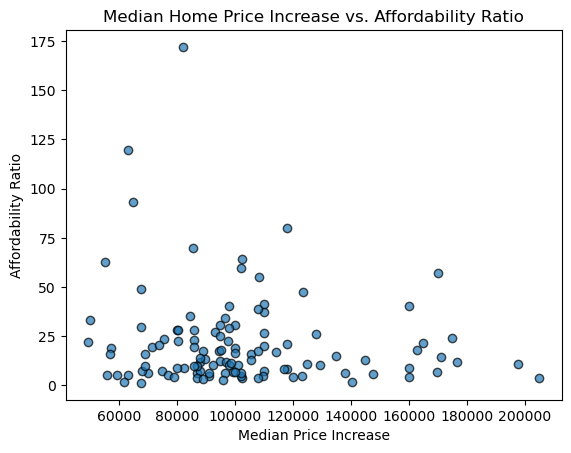

In [67]:

# Is there a correlation between Median Home Price Increases and Affordability Ratio?

x_value = housingdatafinal['Median Price Increase']
y_value = housingdatafinal['Affordability Ratio']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Median Price Increase and Affordability Ratio is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black')
plt.xlabel('Median Price Increase')
plt.ylabel('Affordability Ratio')
plt.title('Median Home Price Increase vs. Affordability Ratio')

# No.  there is little to no correlation between Median Home Price Increases and Affordability Ratio.

The correlation between Median Household Income and Poverty Percent is -0.8.


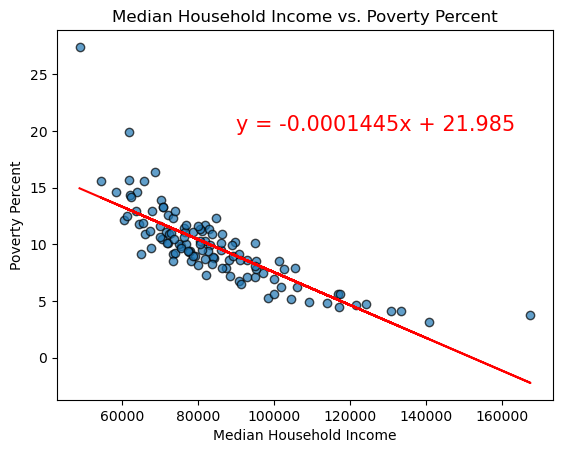

In [70]:

# Is there a correlation between Median Home Price Increases and Affordability Ratio?

x_value = housingdatafinal['Median Household Income']
y_value = housingdatafinal['Poverty Percent']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Median Household Income and Poverty Percent is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black')
plt.xlabel('Median Household Income')
plt.ylabel('Poverty Percent')
plt.title('Median Household Income vs. Poverty Percent')

# Linear regression model

lin_reg = st.linregress(x_value, y_value) 

regress_plot = x_value*lin_reg.slope + lin_reg.intercept
lineequation = 'y = ' +str(round(lin_reg.slope,7)) + 'x + ' + str(round(lin_reg.intercept, 3))

plt.plot(x_value, regress_plot, color='red')
marker_size=15
plt.annotate(lineequation, (90000,20), fontsize=15, color = 'red')
plt.show()

# Yes.  there is a strong correlation between Median Household Income and Poverty Percent.